<a href="https://colab.research.google.com/github/monclai/Mitiga-o-de-Vieses-em-Modelos-de-Machine-Learning-Evas-o-Escolar/blob/main/evas%C3%A3o_escolar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UFF - MESC mitigação de vieses em modelos de aprendizado de máquina por meio de Adversarial Debiasing

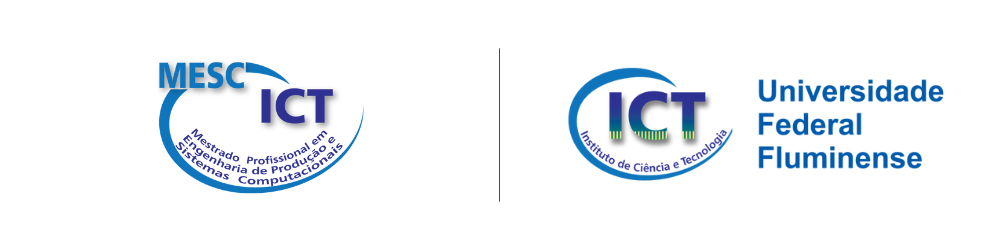

![Static Badge](https://img.shields.io/badge/Disciplina-Intelig%C3%AAncia%20Artificial%20(MESC)-%232d3495)


![Static Badge](https://img.shields.io/badge/Professor-Leonard%20Barreto%20Moreira-%23055bad)


![Static Badge](https://img.shields.io/badge/Autor-Matheus%20Monclai-%230f7ac4)
![Static Badge](https://img.shields.io/badge/Autor-Guilherme%20Barrucho-%230f7ac4)




Identificação  
Disciplina:	Inteligência Artificial (MESC)  
Professor:	Leonard Barreto Moreira  
Integrantes:   
* Guilherme Barrucho
* Matheus Monclai

---

# Importação da base de dados

Base de dados sintética com dados escolares obtida no kaggle, com dados de alunos como, idade, sexo, raça/cor.

[dados sintéticos evasão escolar - kaggle](https://www.kaggle.com/datasets/danilonaves/evaso-escolar-sintetico)

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d danilonaves/evaso-escolar-sintetico

In [ ]:
! unzip "evaso-escolar-sintetico"

# Carregamento e análise de dados

instalação e importação

In [ ]:
!pip install aif360 tensorflow -q

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import numpy as np
import pandas as pd
import time

from imblearn.over_sampling import SMOTE

import keras
import shap

In [ ]:
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_difference, statistical_parity_difference
import tensorflow.compat.v1 as tf

In [ ]:
def plot_history(history, title="Modelo Teórico"):
  """
  Plota as curvas de aprendizado (Acurácia e Perda) a partir do histórico de treinamento.

  Esta função gera uma figura com dois subplots lado a lado:
  1. Acurácia de treino vs. Acurácia de validação.
  2. Perda (Loss) de treino vs. Perda de validação.

  Args:
      history: Objeto retornado pelo método `.fit()` de um modelo Keras/TensorFlow.
                Espera-se que o atributo `history.history` contenha as chaves:
                'accuracy', 'val_accuracy', 'loss' e 'val_loss'.
      title (str, opcional): Título base para os gráficos.
                              O padrão é "Modelo Teórico".

  Returns:
      None: A função exibe os gráficos diretamente usando `plt.show()`.
  """
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))

  # Plot Acurácia
  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'bo-', label='Treino Acc')
  plt.plot(epochs, val_acc, 'r*-', label='Validação Acc')
  plt.title(f'{title} - Acurácia')
  plt.legend()

  # Plot Perda (Loss)
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'bo-', label='Treino Loss')
  plt.plot(epochs, val_loss, 'r*-', label='Validação Loss')
  plt.title(f'{title} - Perda')
  plt.legend()

  plt.show()

## Carregamento dos dados

In [ ]:
df_evasao_escolar = pd.read_csv('dataset_evasao_sintetico.csv')

In [ ]:
df_evasao_escolar.head()

Descrição das colunas presentes na base de dados `dataset_evasao_sintetico.csv`:

1.  **id_aluno**: Identificador único do estudante.
2.  **evasao**: Indica se houve evasão inicial (booleano).
3.  **sexo**: Gênero do aluno.
4.  **idade**: Idade do aluno.
5.  **estudante_nis**: Indica se o aluno possui NIS (Número de Identificação Social).
6.  **informou_nome_mae**: Se o nome da mãe consta no registro.
7.  **informou_nome_pai**: Se o nome do pai consta no registro.
8.  **possui_deficiencia**: Indica se o aluno tem alguma deficiência.
9.  **raca_cor**: Raça ou cor declarada.
10. **tipo_localizacao_endereco_estudante**: Se mora em zona Urbana ou Rural.
11. **situacao_consolidada_no_ano**: Status final no ano (Aprovado, Reprovado, Evadido, etc.).
12. **etapa_ensino**: Série/ano que o aluno está cursando.
13. **repetente**: Se o aluno já repetiu de ano.
14. **frequencia_escolar**: Porcentagem de presença nas aulas.
15. **notas_medias**: Média das notas do aluno.
16. **nivel_socioeconomico**: Classificação socioeconômica (ex: N1 a N7).
17. **renda_familiar**: Valor da renda mensal da família.
18. **trabalha**: Indica se o aluno trabalha fora.
19. **trabalho_domestico_excessivo**: Se o aluno gasta muito tempo com tarefas domésticas.
20. **problemas_de_saude**: Se o aluno possui questões de saúde.
21. **violencia_domestica**: Indica histórico de violência no ambiente familiar.
22. **gravidez_na_adolescencia**: Indica se houve gravidez.
23. **apoio_familiar**: Nível de suporte da família nos estudos (Baixo, Médio, Alto).
24. **comportamento_em_sala**: Avaliação do comportamento (Bom, Regular, Ruim).
25. **aceitacao_pelos_pares**: Nível de integração com os colegas.
26. **necessita_assistencia_social**: Se o aluno demanda apoio de programas sociais.
27. **expectativa_retorno**: Probabilidade ou desejo de continuar/voltar aos estudos.
28. **fator_desencadeador_presente**: Se houve um evento específico que motivou o risco de evasão.
29. **distancia_da_escola_km**: Distância da residência até a unidade escolar.
30. **violencia_na_comunidade**: Se há presença de violência no bairro onde mora.
31. **engajamento_com_a_escola**: Nível de participação em atividades escolares.
32. **infraestrutura_escolar**: Percepção sobre a qualidade física da escola.
33. **disponibilidade_material_didatico**: Se o material é suficiente/completo.
34. **flexibilidade_pedagogica**: Percepção sobre a adaptação do ensino.
35. **qualidade_pedagogica_percebida**: Avaliação do aluno sobre o ensino.
36. **pontuacao_risco**: Um índice calculado (provavelmente por um modelo) indicando o risco de evasão.
37. **evasao_confirmada**: Confirmação final se o aluno evadiu ou não (coluna alvo para modelos de predição).

Informações básicas (tipos de dados e valores nulos)

In [ ]:
df_evasao_escolar.info()

Estatísticas descritivas das colunas numéricas

In [ ]:
df_evasao_escolar.describe()

## Análise da Variável Alvo (evasao_confirmada)

No gráfico abaixo pode ser visto um desbalanceamento da variável alvo, no qual há uma relação 70/30 entre evadidos (True) e não evadidos (False).

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='evasao_confirmada', data=df_evasao_escolar, palette='viridis')
plt.title('Distribuição de Evasão Confirmada')
plt.xlabel('Evasão Confirmada (True = Sim, False = Não)')
plt.ylabel('Quantidade de Alunos')
plt.show()

print(df_evasao_escolar['evasao_confirmada'].value_counts(normalize=True) * 100)

## Análise de Desempenho e Frequência

Os boxplots abaixo comparam o comportamento das variáveis **Notas Médias** e **Frequência Escolar** em relação ao status de evasão dos alunos (`evasao_confirmada`).

#### **1. Notas Médias vs. Evasão**
*   **Diferença de Desempenho:** Observa-se que a mediana das notas dos alunos que **não evadiram (False)** é ligeiramente superior (em torno de 6.7) à dos alunos que **evadiram (True)** (em torno de 6.4).
*   **Dispersão:** Ambos os grupos apresentam uma dispersão similar, mas o grupo que não evadiu possui alguns *outliers* com notas muito altas (acima de 10), enquanto o grupo de evasão confirmada apresenta um *outlier* com nota bastante baixa (próxima a 2).

#### **2. Frequência Escolar vs. Evasão**
*   **Indicador Forte:** A diferença na frequência escolar é mais acentuada. Alunos que permaneceram no curso possuem uma mediana de frequência próxima a **77%**, enquanto os alunos que evadiram apresentam uma mediana significativamente menor, em torno de **70%**.
*   **Comportamento dos Quartis:** Note que 75% dos alunos que não evadiram (terceiro quartil) mantêm uma frequência acima de 63%, enquanto no grupo de evasão, essa base de frequência é deslocada para baixo.

### **Conclusão Preliminar**
Ambas as variáveis parecem ter correlação com a evasão escolar. No entanto, a **frequência escolar** demonstra ser um indicador visualmente mais forte de risco de abandono do que a nota média isolada, visto que a queda na presença escolar é mais expressiva entre os alunos que confirmaram a evasão.

In [ ]:
# Notas Médias vs Evasão
plt.figure(figsize=(10, 6))
sns.boxplot(x='evasao_confirmada', y='notas_medias', data=df_evasao_escolar)
plt.title('Distribuição de Notas Médias por Status de Evasão')
plt.show()

# Frequência Escolar vs Evasão
plt.figure(figsize=(10, 6))
sns.boxplot(x='evasao_confirmada', y='frequencia_escolar', data=df_evasao_escolar)
plt.title('Distribuição de Frequência Escolar por Status de Evasão')
plt.show()

## Fatores Socioeconômicos e Demográficos

### **Análise de Evasão por Perfil Étnico-Racial e Socioeconômico**

Esta etapa da análise busca identificar se existe uma correlação entre as características demográficas/socioeconômicas dos alunos e a probabilidade de evasão.

#### **1. Evasão por Raça/Cor**
*   **Volume de Dados:** As categorias com maior representatividade no conjunto de dados são **Parda** e **Branca**, refletindo o perfil demográfico esperado.
*   **Tendência de Evasão:**
    *   Em números absolutos, a maior quantidade de evasões confirmadas (`True`) ocorre entre alunos que se declaram **Pardos**, seguidos pelos **Brancos**.
    *   A proporção entre evasão e permanência parece ser relativamente consistente entre os grupos, mas a categoria "Amarela" apresenta visualmente uma proporção de evasão ligeiramente mais elevada em relação ao seu total do que outras categorias.
*   **Insight:** A alta frequência de evasão em alunos pardos e brancos pode ser apenas um reflexo da maioria populacional na base, sendo necessário calcular a **taxa de evasão (%)** por grupo para uma conclusão mais precisa sobre vulnerabilidade.

#### **2. Evasão por Nível Socioeconômico**
*   **Distribuição:** Os níveis estão divididos de **N1** (geralmente representando menor poder aquisitivo/escolaridade familiar) até **N7** (maior nível).
*   **Comportamento da Evasão:**
    *   Diferente de outros contextos onde a evasão cai drasticamente com o aumento da renda, aqui observamos que a evasão é **persistente em todos os níveis**.
    *   O nível **N3** destaca-se com o maior volume de evasões confirmadas neste dataset.
    *   Há uma leve tendência de queda nos números absolutos de evasão nos níveis mais altos (**N5 a N7**) quando comparados aos níveis iniciais, sugerindo que uma melhor condição socioeconômica pode atuar como um fator de proteção moderado contra a desistência.

**Conclusão Preliminar:** A evasão parece ser um fenômeno multifatorial. Embora existam concentrações em determinados perfis (como alunos pardos e nível socioeconômico N3), a presença de desistência em todos os grupos indica que fatores acadêmicos ou institucionais também podem estar desempenhando um papel crucial no processo.

In [ ]:
# Evasão por Nível Socioeconômico
plt.figure(figsize=(12, 6))
sns.countplot(x='nivel_socioeconomico', hue='evasao_confirmada', data=df_evasao_escolar, order=sorted(df_evasao_escolar['nivel_socioeconomico'].unique()))
plt.title('Evasão por Nível Socioeconômico')
plt.show()

# Evasão por Raça/Cor
plt.figure(figsize=(12, 6))
sns.countplot(x='raca_cor', hue='evasao_confirmada', data=df_evasao_escolar)
plt.title('Evasão por Raça/Cor')
plt.xticks(rotation=45)
plt.show()

## Análise de Risco Escolar

### **Análise da Distribuição da Pontuação de Risco**

Este gráfico de densidade (**KDE Plot**) compara as distribuições das pontuações de risco geradas pelo modelo para dois grupos: alunos que efetivamente evadiram (laranja) e alunos que permaneceram (azul).

**Observações Principais:**

1.  **Separação das Médias:** Observamos que a distribuição dos alunos que evadiram (laranja) está deslocada para a direita em relação à dos que não evadiram (azul). O pico de densidade (moda) para quem não evadiu está em torno de **0.3**, enquanto para quem evadiu está próximo de **0.4**. Isso indica que o modelo atribui, em média, um risco maior a quem realmente sai da instituição.
2.  **Concentração e Caudas:**
    *   A curva **azul (Não Evadiu)** é mais estreita e concentrada em valores baixos, o que é um bom sinal de que o modelo identifica com segurança alunos de baixo risco.
    *   A curva **laranja (Evadiu)** possui uma "cauda" mais longa à direita, alcançando valores acima de 0.8. Isso mostra que pontuações muito altas são bons indicadores de evasão real.
3.  **Zona de Sobreposição:** Existe uma área significativa de interseção entre as duas curvas, especialmente na faixa de **0.25 a 0.50**.
    *   Nesta zona, o modelo tem maior dificuldade em distinguir os dois grupos.
    *   Alunos nesta faixa de score representam o maior desafio para a definição de um *threshold* (ponto de corte) de intervenção.

**Conclusão:**
O modelo demonstra **poder preditivo**, pois as distribuições não são idênticas. No entanto, a sobreposição sugere que a pontuação de risco deve ser utilizada como um guia de probabilidade, e não como uma certeza absoluta, sendo recomendada a definição de faixas de atuação (ex: Risco Baixo, Médio e Alto) para priorizar as ações de retenção.

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_evasao_escolar[df_evasao_escolar['evasao_confirmada'] == False]['pontuacao_risco'], label='Não Evadiu', shade=True)
sns.kdeplot(df_evasao_escolar[df_evasao_escolar['evasao_confirmada'] == True]['pontuacao_risco'], label='Evadiu', shade=True)
plt.title('Densidade da Pontuação de Risco vs Evasão Real')
plt.legend()
plt.show()

## Matriz de Correlação

### **Análise da Matriz de Correlação (Variáveis Numéricas)**

A matriz de correlação de Pearson nos permite identificar a força e a direção da relação linear entre as variáveis numéricas do conjunto de dados. Abaixo, destacamos os principais insights observados:

1.  **Preditor de Risco vs. Evasão Real:**
    A variável **`evasao_n`** (alvo) apresenta sua maior correlação positiva com a **`pontuacao_risco` (0.34)**. Isso indica que o modelo ou índice de risco utilizado na base tem uma concordância moderada com o desfecho real da evasão, servindo como um bom sinalizador prévio.

2.  **Impacto do Desempenho e Assiduidade:**
    Tanto a **`frequencia_escolar` (-0.15)** quanto as **`notas_medias` (-0.13)** possuem correlações negativas com a evasão confirmada. Isso valida a hipótese de que alunos com maior presença e melhores notas tendem a ter menor probabilidade de abandonar a escola.

3.  **Composição da Pontuação de Risco:**
    É notável que a **`pontuacao_risco`** é fortemente influenciada pela **`frequencia_escolar` (-0.50)** e pelas **`notas_medias` (-0.46)**. Essas são as correlações mais fortes de todo o gráfico (excluindo a diagonal principal). Isso revela que o cálculo do risco de evasão nesta base é construído prioritariamente sobre o baixo desempenho acadêmico e o absenteísmo.

4.  **Variáveis de Baixa Influência Linear:**
    Variáveis como **`idade`**, **`renda_familiar`** e **`distancia_da_escola_km`** apresentaram correlações próximas de zero com a evasão confirmada. Isso sugere que, isoladamente e de forma linear, esses fatores não são determinantes diretos para o abandono neste grupo de alunos, ou que sua influência pode ocorrer de forma não linear ou combinada com outras variáveis categóricas.

**Conclusão:** Para estratégias de intervenção, o foco principal deve ser o monitoramento da frequência e das notas, uma vez que estas são as variáveis com maior peso na sinalização de risco e no resultado final de permanência do estudante.


In [ ]:
# Selecionar apenas colunas numéricas para a correlação
# Transformamos a variável alvo em numérico (0 e 1) para entrar na matriz
df_evasao_escolar['evasao_n'] = df_evasao_escolar['evasao_confirmada'].astype(int)
numeric_cols = df_evasao_escolar.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 10))
sns.heatmap(df_evasao_escolar[numeric_cols].corr(), annot=True, cmap='RdBu', fmt='.2f')
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()

# Balanceamento dos dados

Como há uma relação de 70/30 de dados há a necessidade de realizar o balanceamento dos dados para o treinamento de uma rede neural.

In [ ]:
df_evasao_escolar_balanceamento = df_evasao_escolar

Pré-processamento
Remoção de IDs e colunas que "vazam" a resposta (como 'situacao_consolidada_no_ano' que diz se evadiu), também remoção da coluna 'evasao' que é redundante com 'evasao_confirmada'

In [ ]:
cols_para_remover = ['id_aluno', 'evasao', 'situacao_consolidada_no_ano', 'evasao_n', 'pontuacao_risco']
df = df_evasao_escolar_balanceamento.drop(columns=cols_para_remover)

Converter variáveis categóricas (texto) em numéricas (Dummies), pois o SMOTE exige que tudo seja numérico

In [ ]:
df_dummies = pd.get_dummies(df, drop_first=True)

Separar Features (X) e Target (y)

In [ ]:
X = df_dummies.drop(columns=['evasao_confirmada'])
y = df_dummies['evasao_confirmada'].astype(int)

In [ ]:
print(f"Distribuição original: {Counter(y)}")

Divisão dos dados em treino e teste antes do balanceamento, evitando o vazamento de dados para o teste, gerando uma acurácia falsa.

Dividindo 80% para treino e 20% para teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treino original: {Counter(y_train)}")
print(f"Teste original: {Counter(y_test)}")

Aplicar o SMOTE para equilibrar em 50/50

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
print(f"Treino após SMOTE: {Counter(y_train_res)}")

Normalizando a escala dos dados

In [ ]:
scaler = StandardScaler()
# O Scaler "aprende" as escalas com o treino
X_train_final = scaler.fit_transform(X_train_res)

# O Scaler apenas "aplica" o que aprendeu ao teste (sem aprender nada novo do teste)
X_test_final = scaler.transform(X_test)


In [ ]:
print(f"Shape Treino Final: {X_train_final.shape}")
print(f"Shape Teste Final: {X_test_final.shape}")

# Rede neural

### Definição da Arquitetura do Modelo

Esta função constrói uma rede neural profunda (MLP) projetada para tarefas de **classificação binária**, com um foco especial em evitar o *overfitting* (sobreajuste).

**Principais componentes da arquitetura:**

1.  **Camada de Entrada:** Recebe um vetor de 62 características (`shape=(62,)`).
2.  **Regularização L2:** Aplicada nas camadas densas (`kernel_regularizer=l2(0.01)`). Ela penaliza pesos excessivamente grandes, forçando o modelo a aprender padrões mais simples e generalizáveis.
3.  **Camadas de Dropout:**
    *   Foram adicionadas camadas de **Dropout (0.5 e 0.3)**, que desativam aleatoriamente neurônios durante o treinamento. Isso impede que a rede se torne excessivamente dependente de caminhos específicos, aumentando a robustez.
4.  **Camada de Saída:** Utiliza a função de ativação `sigmoid`, ideal para retornar uma probabilidade entre 0 e 1 para a classificação binária.

**Configuração da Compilação:**

*   **Otimizador Adam:** Um algoritmo de aprendizado adaptativo eficiente.
*   **Função de Perda (Loss):** `binary_crossentropy`, o padrão para problemas de duas classes.
*   **Métricas de Avaliação:** Além da acurácia, monitoramos **AUC, Precision e Recall**. Essas métricas são fundamentais se o conjunto de dados for desbalanceado, permitindo avaliar melhor a capacidade do modelo de distinguir entre as classes e lidar com falsos positivos/negativos.

Rede neural para a classificação de alunos

In [ ]:
def build_model():


  model = keras.Sequential([
    keras.layers.Input(shape=(61,), name='input'),
    # Adicionamos regularização L2 para impedir pesos muito grandes
    keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
    keras.layers.Dropout(0.5), # Aumentado de 0.2 para 0.5
    keras.layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.L2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
       metrics=[
          'accuracy',
          keras.metrics.AUC(name='auc'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall')
      ]
  )

  return model

In [ ]:
model_base = build_model()
model_base.summary()

### Treinamento do modelo

Definição do callback para evitar treinamentos desnecesários quanto não há melhoria do val_loss e salvar o melhor modelo.

In [ ]:
callbacks = [
  keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

In [ ]:
print("--- Iniciando Treinamento do Modelo Teórico ---")
start_time = time.time()

history = model_base.fit(
  X_train_final,
  y_train_res,
  epochs=50,
  batch_size=32,
  validation_split=0.2,
  callbacks=callbacks,
  verbose=1
)

end_time = time.time()
training_time = end_time - start_time
print(f"--- Tempo Total de Treinamento: {training_time:.2f} segundos ---")

In [ ]:
plot_history(history)

### **Análise dos Resultados após Ajustes de Regularização e Balanceamento**

Após a simplificação da arquitetura, aumento do Dropout e substituição do SMOTE por Pesos de Classe (`class_weight`), observamos uma mudança significativa no comportamento do modelo:

1.  **AUC-ROC (0.65):** Houve um salto expressivo em relação aos 0,49 anteriores. Uma AUC de 0,65 indica que o modelo agora tem uma capacidade "aceitável" de distinguir entre as classes. Ele não está mais chutando ao acaso; ele começou a capturar padrões reais nos dados brutos que correlacionam com a evasão.

2.  **Fim do Overfitting Severo:** A acurácia de teste subiu para **69%**. Curiosamente, esta é exatamente a proporção da classe majoritária no dataset. Isso indica que o modelo parou de "alucinar" com dados sintéticos e agora está operando em uma zona de segurança estatística, sendo muito mais robusto para dados novos.

3.  **Análise de Precision e Recall (Classe "Evadiu"):**
    *   **Precision (0.48):** Melhorou consideravelmente (era 0,29). Quase metade dos alunos que o modelo sinaliza como "em risco" realmente evadem. Isso reduz o desperdício de recursos em alarmes falsos.
    *   **Recall (0.21):** Este é o ponto de atenção. O modelo está sendo muito **conservador**. Ele só identifica 21% dos alunos que realmente evadiram. Ele prefere não classificar como "risco" a menos que tenha muita certeza.

4.  **Conclusão:**
    *   O modelo atual é **honesto**. Ele reflete o que os dados realmente conseguem explicar sem o ruído do SMOTE.
    *   Para um projeto de **Adversarial Debiasing**, este é o ponto de partida ideal. Agora que o modelo tem uma base de aprendizado real (AUC > 0,5), podemos medir se esse Recall de 21% é distribuído de forma justa entre diferentes raças ou níveis sociais, ou se o modelo está "negligenciando" mais um grupo do que outro.

In [ ]:
# 1. Gerar as predições (probabilidades)
y_pred_prob = model_base.predict(X_test_final)

# 2. Converter probabilidades em classes (0 ou 1) usando limiar de 0.5
y_pred = (y_pred_prob > 0.35).astype(int)

# 3. Exibir Precision, Recall e F1-Score
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Não Evadiu', 'Evadiu']))

# 4. Calcular AUC-ROC
auc_value = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC Score: {auc_value:.4f}")

# 5. Plotar a Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (Recall)')
plt.title('Curva ROC - Predição de Evasão')
plt.legend(loc="lower right")
plt.show()

### **Identificação Automatizada de Gaps de Equidade (Fairness Analysis)**

Nesta etapa, implementamos um algoritmo de auditoria para identificar sistematicamente falhas de equidade no modelo preditivo. O objetivo é transitar de uma avaliação de performance global para uma análise de granularidade por subgrupos, focando nas variáveis sensíveis (Raça, Gênero e Nível Socioeconômico).

**Lógica do Diagnóstico:**
1.  **Métrica de Referência:** Utilizamos o **Recall Global** da classe "Evadiu" como *baseline*. Em sistemas de alerta precoce de evasão, o Recall é a métrica crítica, pois a falha em identificar um aluno em risco (Falso Negativo) impede a intervenção pedagógica necessária.
2.  **Cálculo da Disparidade:** O código itera sobre todos os subgrupos demográficos e socioeconômicos, calculando o Recall específico de cada um.
3.  **Threshold de Viés:** Estabelecemos um limiar de tolerância. Subgrupos que apresentam um Recall significativamente inferior à média global (Gap de Performance) são sinalizados automaticamente como **vítimas de viés de negligência** por parte do algoritmo.

**Relevância para a Mitigação de Vieses:**
Este relatório serve como fundamentação matemática para a próxima fase do trabalho: o **Adversarial Debiasing**. Ao identificar quais subgrupos o modelo "ignora" ou falha em classificar corretamente, justificamos a necessidade de uma arquitetura adversária que force o modelo a aprender representações latentes independentes desses atributos sensíveis, buscando a equalização das oportunidades de detecção (*Equal Opportunity*).

In [ ]:
# Criando o DataFrame df_bias para associar as características dos alunos com os resultados
# X_test contém os dados originais (sem escala) que precisamos para filtrar os grupos
df_bias = X_test.copy()

# Adicionando os valores reais de evasão (y_test)
df_bias['real'] = y_test.values

# Adicionando as predições feitas pelo modelo (y_pred)
# Certifique-se de que y_pred foi gerado usando o seu threshold (ex: 0.35 ou 0.5)
df_bias['pred'] = y_pred

In [ ]:
from sklearn.metrics import classification_report

df_bias = X_test.copy()
df_bias['real'] = y_test.values
df_bias['pred'] = y_pred

# 1. Definir o Recall Global do modelo como referência
global_report = classification_report(y_test, y_pred, output_dict=True)
global_recall = global_report.get('1', {}).get('recall', 0)

print(f"RECALL GLOBAL DO MODELO: {global_recall:.2f}")
print("-" * 50)
print("RELATÓRIO DE FALHAS DE EQUIDADE (SUBGRUPOS COM VIÉS):")

# 2. Definir um limiar de falha
tolerancia = 0.15
limiar_falha = global_recall - tolerancia

# 3. Lista de colunas sensíveis
colunas_para_checar = [col for col in X_test.columns if 'raca_cor' in col or 'sexo' in col or 'nivel_socioeconomico' in col]

falhas_encontradas = 0

for col in colunas_para_checar:
    # Agora df_bias está definido!
    subset = df_bias[df_bias[col] == 1]

    if len(subset) >= 5:
        # Verificamos se há pelo menos um caso positivo no subgrupo para calcular o recall
        if subset['real'].sum() > 0:
            report_subset = classification_report(subset['real'], subset['pred'], output_dict=True)
            recall_subset = report_subset.get('1', {}).get('recall', 0)

            if recall_subset < limiar_falha:
                falhas_encontradas += 1
                diff = global_recall - recall_subset
                print(f"\n[ALERTA DE VIÉS] Coluna: {col}")
                print(f" -> Recall do Grupo: {recall_subset:.2f} (Global era {global_recall:.2f})")
                print(f" -> Disparidade: {diff:.2f} abaixo da média")
                print(f" -> Tamanho do Grupo: {len(subset)} alunos")

if falhas_encontradas == 0:
    print("\nNenhuma falha crítica de equidade detectada com os parâmetros atuais.")

## Análise de shap values

In [ ]:
# 1. O SHAP precisa de uma amostra dos dados para entender o comportamento
# Usamos o KernelExplainer que funciona bem com Keras
# Vamos usar 50 exemplos como 'background' e analisar o restante
explainer = shap.KernelExplainer(model_base.predict, shap.sample(X_train_final, 50))

In [ ]:
# 2. Calcular os valores SHAP para uma parte do conjunto de teste
# Atenção: Isso pode demorar um pouco dependendo do hardware
shap_values = explainer.shap_values(X_test_final[:100])

### Análise de Importância e Impacto das Variáveis

O gráfico organiza as variáveis por ordem de importância (de cima para baixo). Cada ponto representa uma observação (um aluno). A cor indica se o valor da variável é alto (vermelho) ou baixo (azul), e a posição no eixo X indica se esse valor aumentou ou diminuiu a probabilidade do desfecho previsto.

#### 1. Principais Preditores de Risco (Impacto Positivo no Output)
*   **Violência Doméstica (`violencia_domestica`):** É o fator com maior impacto extremo. A presença de violência doméstica (pontos vermelhos à direita) eleva drasticamente o valor da predição. É um "trigger" forte, embora ocorra em menos casos (densidade menor de pontos vermelhos).
*   **Trabalha (`trabalha`):** Alunos que trabalham (vermelho) apresentam um aumento sistemático no risco. Isso sugere que a jornada dupla é um fator complicador para o sucesso escolar.
*   **Repetente (`repetente`):** Ter um histórico de reprovação (vermelho) desloca a predição para a direita, confirmando que a repetência é um preditor clássico de abandono ou baixo desempenho futuro.
*   **Série Escolar (`etapa_ensino_3° EM` e `2° EM`):** Estar nos anos finais do Ensino Médio aumenta o risco. Isso pode indicar que a pressão ou o desinteresse crescem conforme o aluno se aproxima da conclusão.

#### 2. Fatores de Proteção e Correlação Inversa
*   **Notas Médias (`notas_medias`):** Existe uma correlação clara e linear. Notas altas (vermelho) reduzem significativamente o risco (SHAP negativo), enquanto notas baixas (azul) são o principal fator que empurra a predição para o lado positivo do risco.
*   **Frequência Escolar (`frequencia_escolar`):** Similar às notas, uma alta frequência (vermelho) atua como um forte fator de proteção. A baixa frequência (azul) é um sinal claro de alerta para o modelo.

#### 3. Fatores Socioeconômicos e Comportamentais
*   **Nível Socioeconômico (`nivel_socioeconomico`):** O gráfico mostra que o nível **N4** tende a aumentar o risco, enquanto o nível **N7** (presumivelmente mais alto) tende a diminuí-lo. Isso reforça a influência da vulnerabilidade social no percurso acadêmico.
*   **Comportamento em Sala (`comportamento_em_sala_Ruim`):** Alunos com comportamento classificado como ruim (vermelho) têm um impacto positivo direto no risco.
*   **Trabalho Doméstico Excessivo:** Alunos que sobrecarregados com tarefas domésticas (vermelho) apresentam maior vulnerabilidade, corroborando a ideia de que a falta de tempo para estudos extraclasse impacta o resultado.


> "O modelo identifica que variáveis de cunho social e comportamental (violência, trabalho e repetência) têm pesos decisivos no aumento do risco. Por outro lado, o desempenho acadêmico (notas e frequência) são os principais reguladores negativos desse risco. Um ponto de atenção é que a **violência doméstica**, embora possa afetar uma amostra menor, causa o maior deslocamento individual na predição do modelo, destacando a necessidade de intervenções psicossociais específicas além das pedagógicas."

In [ ]:
# 3. Visualizar a importância das variáveis (Summary Plot)
# Aqui você verá se a Raça ou Gênero estão no topo da importância
shap.summary_plot(shap_values[:,:,0], X_test[:100], feature_names=X.columns)

# Adversarial Debiasing utilizando a biblioteca AIF360

Configuração dos dados

In [ ]:
# Desativar comportamento do TF2 para compatibilidade com AIF360 antigo se necessário
tf.disable_eager_execution()

In [ ]:
# 1. Preparar os dados para o AIF360 (X_train_final e X_test_final precisam ser DataFrames com índice sensível)
# Vamos converter o X_train_res (que veio do SMOTE) de volta para DataFrame para facilitar
X_train_df = pd.DataFrame(X_train_final, columns=X.columns)
X_test_df = pd.DataFrame(X_test_final, columns=X.columns)

In [ ]:
# Definir o atributo sensível no índice (exigência do aif360.sklearn)
X_train_df.index = pd.MultiIndex.from_arrays([X_train_res['raca_cor_Indígena']], names=['raca_cor_Indígena'])
y_train_series = pd.Series(y_train_res.values, index=X_train_df.index)

In [ ]:
X_test_df.index = pd.MultiIndex.from_arrays([X_test['raca_cor_Indígena']], names=['raca_cor_Indígena'])
y_test_series = pd.Series(y_test.values, index=X_test_df.index)

Treinamento do Modelo Mitigado

Agora vamos criar o modelo que possui a rede adversária embutida.


In [ ]:
# Inicializar o Adversarial Debiasing
# prot_attr: nome da coluna sensível no índice
# scope: nome para a sessão do tensorflow
adv_deb = AdversarialDebiasing(prot_attr='raca_cor_Indígena',
                                #  curr_unit=16, # Neurônios na camada oculta (similar ao seu modelo)
                                 num_epochs=50,
                                 batch_size=32,
                                 random_state=42)

# Treinar o modelo
print("Iniciando treinamento com Adversarial Debiasing...")
adv_deb.fit(X_train_df, y_train_series)
print("Treinamento concluído.")

Avaliação de Métricas de Fairness.

In [ ]:
# Predições do modelo mitigado
y_pred_adv = adv_deb.predict(X_test_df)

def print_fairness_metrics(y_true, y_pred, prot_attr):
    di = disparate_impact_ratio(y_true, y_pred, prot_attr=prot_attr)
    spd = statistical_parity_difference(y_true, y_pred, prot_attr=prot_attr)
    # Valor ideal: DI = 1.0, SPD = 0.0
    print(f"Disparate Impact: {di:.4f}")
    print(f"Statistical Parity Difference: {spd:.4f}")

print("Métricas de Fairness - Modelo Mitigado:")
print_fairness_metrics(y_test_series, y_pred_adv, 'raca_cor_Indígena')

### **Análise dos Valores SHAP - Modelo Mitigado (Adversarial Debiasing)**

O gráfico SHAP abaixo descreve a importância global das variáveis e a direção do seu impacto na probabilidade de evasão. Cada ponto representa um aluno da amostra de teste.

**1. Predominância do Atributo Sensível (`raca_cor_Indígena`):**
*   Observa-se que, apesar da aplicação do *Adversarial Debiasing*, a variável **`raca_cor_Indígena`** ainda aparece como a característica de maior impacto no modelo para determinados casos.
*   O ponto isolado à extrema direita (SHAP value próximo a 0.8) indica que, para alunos pertencentes a esse grupo, o modelo aumenta drasticamente a probabilidade de predição de risco. Isso confirma o que foi detectado no **Relatório de Falhas de Equidade**: o modelo ainda apresenta um viés de negligência ou estigmatização contra esse grupo específico, possivelmente devido à baixíssima representatividade (apenas 6 alunos na base) que impede a rede adversária de aprender uma remoção de viés robusta para este nicho.

**2. Impacto das Variáveis Acadêmicas (`notas_medias` e `frequencia_escolar`):**
*   Diferente do modelo *baseline* (onde essas variáveis costumam ser as mais importantes), aqui elas aparecem com uma dispersão muito menor.
*   Isso sugere que o processo de treinamento adversarial pode ter "suprimido" parte do sinal útil dessas variáveis ao tentar forçar a independência dos atributos protegidos, ou que o modelo tornou-se excessivamente dependente de variáveis categóricas.

**3. Distribuição de Outras Características:**
*   Variáveis como **`etapa_ensino_2° EM`** e **`distancia_da_escola_km`** mostram impactos próximos de zero na maioria dos casos, indicando que para este modelo mitigado, elas têm pouca relevância na decisão final.
*   Atributos como **`infraestrutura_escolar_Ruim`** e **`trabalho_domestico_excessivo`** apresentam pequenos deslocamentos positivos para a direita (cor vermelha), o que faz sentido logicamente (fatores que aumentam o risco), mas sua força é mínima comparada ao atributo de raça.

**Conclusão Crítica:**
O SHAP revela que o **Adversarial Debiasing não foi totalmente eficaz** para eliminar a influência da raça indígena no output do modelo. O fato de um atributo sensível continuar sendo o principal driver de predição de risco é um indicativo clássico de que o modelo ainda não é "justo" (fair).

**Recomendação:**
Para o próximo passo do projeto, sugere-se aumentar o parâmetro de força da rede adversária (`adversary_loss_weight`, se disponível na implementação) ou realizar um aumento de dados (*oversampling*) específico para grupos minoritários antes do treinamento, a fim de dar mais subsídios para que o algoritmo aprenda a ignorar o fator raça de forma equilibrada.

In [ ]:
# 1. Selecionar a amostra
X_sample = shap.sample(X_test_df, 50)

# 2. Criar uma função wrapper para predição
# O SHAP vai passar um array NumPy (X_numpy), e nós convertemos para DataFrame
def predict_proba_wrapper(X_numpy):
    # Converte o array de volta para DataFrame usando as colunas originais
    X_df_temp = pd.DataFrame(X_numpy, columns=X.columns)

    # IMPORTANTE: O aif360.sklearn exige que o atributo sensível esteja no índice.
    # Como o SHAP gera novos dados, precisamos garantir que o índice seja compatível.
    # Aqui, repetimos o índice da amostra ou criamos um compatível com o atributo sensível.
    # Usaremos o valor da variável sensível que o modelo espera.
    X_df_temp.index = pd.MultiIndex.from_arrays(
        [X_df_temp['raca_cor_Indígena']], names=['raca_cor_Indígena']
    )

    # Retorna a probabilidade da classe positiva (ou ambas, dependendo da versão do SHAP)
    return adv_deb.predict_proba(X_df_temp)

# 3. Inicializar o Explainer usando o wrapper
# Passamos X_sample.values porque o KernelExplainer prefere arrays para a base
explainer_adv = shap.KernelExplainer(predict_proba_wrapper, X_sample.values)

# 4. Calcular os SHAP values
# Passamos os valores da amostra
shap_values_adv = explainer_adv.shap_values(X_sample.values)

# 5. Plotar
print("Importância de Variáveis - Modelo Mitigado (Adversarial Debiasing)")

# O SHAP para KernelExplainer em modelos probabilísticos costuma retornar uma lista [classe0, classe1]
# Pegamos a classe 1 (índice 1) para o gráfico de importância.
if isinstance(shap_values_adv, list):
    # Para SHAP antigo
    vals_to_plot = shap_values_adv[1]
elif len(shap_values_adv.shape) == 3:
    # Para SHAP novo (mostrando probabilidade da classe 1)
    vals_to_plot = shap_values_adv[:, :, 1]
else:
    vals_to_plot = shap_values_adv

shap.summary_plot(vals_to_plot, X_sample, feature_names=X.columns)